
# Uma breve introdução ao Machine Learning: Dia 4

Gabriel Wendell Celestino Rocha

Material de um minicurso de introdução ao Machine Learning oferecido pelo [PET - Física](https://petfisica.home.blog).

O conteúdo é mantido no [GitHub](https://github.com/GabrielWendell/Intro_ML) e distribuídos sob uma [licença BSD3](https://opensource.org/licenses/BSD-3-Clause).

- [Veja a tabela de conteúdos](https://github.com/GabrielWendell/Intro_ML/blob/main/Infomações/Conteúdos.ipynb)

Este `Notebook` pode, opcionalmente, ser visto como uma [apresentação de slides](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f). para apresentar os slides localmente, use:

```Python
$ jupyter nbconvert Dia4.ipynb --to slides --post serve
```

---

### Bibliotecas necessárias

In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib notebook

def opt_plot():
    # plt.style.use('dark_background')
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                        top = True,right = True, length = 5,width = 1,labelsize = 15)
    plt.tick_params(axis='both',which='major', direction = "in",
                        top = True,right = True, length = 8,width = 1,labelsize = 15)

### Versões das bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Pandas, Seaborn

Software versions
Python 3.9.8 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.0.1
OS Windows 10 10.0.19043
Matplotlib 3.5.1
Numpy 1.22.2
Pandas 1.4.0
Seaborn 0.11.2
Sat Jul 09 10:15:06 2022 Hora Padrão de Buenos Aires

#### Instalação:

```
$ pip install version_information
```

---

Usaremos o [módulo de decomposição](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) do `sklearn` abaixo:

In [3]:
from sklearn import decomposition

# Baixando os dados

In [4]:
cosmo_targets = pd.read_hdf('Data/cosmo_targets.hf5')
cluster_3d = pd.read_hdf('Data/cluster_3d_data.hf5')

In [5]:
line_data = pd.read_csv('Data/line_data.csv')
pong_data = pd.read_hdf('Data/pong_data.hf5')
spectra_data = pd.read_hdf('Data/spectra_data.hf5')

# Dimensionalidade dos dados

Chamamos o número de recursos (colunas) em um conjunto de dados de "dimensionalidade". Para aprender como os diferentes recursos estão relacionados, precisamos de amostras suficientes para obter uma imagem completa.

Por exemplo, imagine dividir cada recurso em seu valor mediano, então, no mínimo, gostaríamos de ter pelo menos uma amostra em cada um dos resultados $2^{D}$ bins ($D$ = dimensionalidade = $\#$ de recursos = $\#$ de colunas). Esta é uma barra muito baixa e requer apenas 8 amostras com $D=3$, mas requer $2^{30}>1$ bilhões de amostras com $D=30$.

Para ter uma ideia de quão bem amostrado é seu conjunto de dados, estime em quantos compartimentos você poderia dividir cada recurso (eixo) e termine com 1 amostra por compartimento (supondo que os recursos não sejam correlacionados). Um valor < 2 falha em nosso teste mínimo acima e qualquer coisa < 5 é uma potencial bandeira vermelha.

In [6]:
stats = []
for name in 'line_data', 'cluster_3d', 'cosmo_targets', 'pong_data', 'spectra_data':
    N, D = eval(name).shape
    stats.append([name, N, D, N**(1/D)])

pd.DataFrame(stats, columns = ('Dataset', 'N', 'D', 'N**(1/D)')).round(3)

,Dataset,N,D,N**(1/D)
0,line_data,2000,3,12.599
1,cluster_3d,500,3,7.937
2,cosmo_targets,50000,6,6.070
3,pong_data,1000,20,1.413
4,spectra_data,200,500,1.011


No entanto, nem todos os recursos carregam informações iguais e a dimensionalidade efetiva de um conjunto de dados pode ser menor que o número de colunas. Como um exemplo extremo, considere os seguintes dados 2D que são efetivamente 1D, pois uma coluna tem um valor constante (zero):

<IPython.core.display.Javascript object>


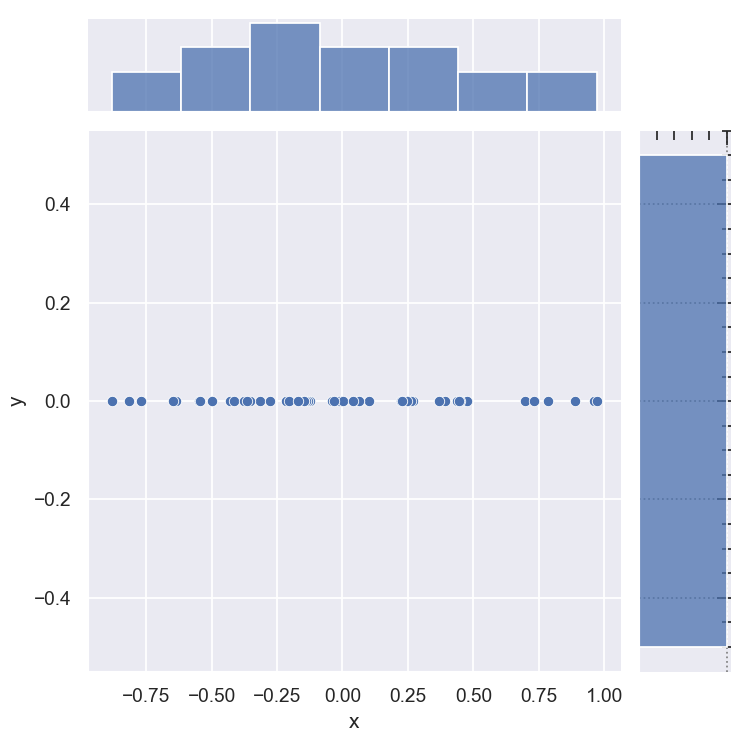

In [7]:
gen = np.random.RandomState(seed = 123)
data = pd.DataFrame()
data['x'] = gen.uniform(-1, +1, 50)
data['y'] = np.zeros_like(data['x'])

sns.jointplot(x = 'x', y = 'y', data = data)
opt_plot()

**QUESTIONAMENTO:** Esses dados ainda são 1D se:

1. adicionamos uma pequena dispersão na 2ª dimensão?
2. realizamos uma rotação de coordenadas para que $y\approx mx$?
3. $y\approx f(x)$ onde $f(x)$ é não linear?

1. A dispersão adiciona novas informações em uma segunda dimensão, mas podemos ignorá-las aproximadamente sob duas suposições:

> - A escala relativa das colunas `x` e `y` é significativa (o que quase certamente não é verdade se essas colunas tiverem dimensões diferentes - lembre-se de nossos comentários anteriores sobre normalização de dados).

> - A origem da dispersão é devido a um erro de medição ou algum outro processo não informativo.

2. A rotação não altera a dimensionalidade efetiva dos dados.

3. Uma relação não linear entre `x` e `y` também não altera a dimensionalidade subjacente, pois poderíamos, em princípio, realizar uma mudança não linear de coordenadas para desfazê-la. No entanto, podemos esperar que as relações não lineares sejam mais difíceis de lidar do que as lineares.

<IPython.core.display.Javascript object>


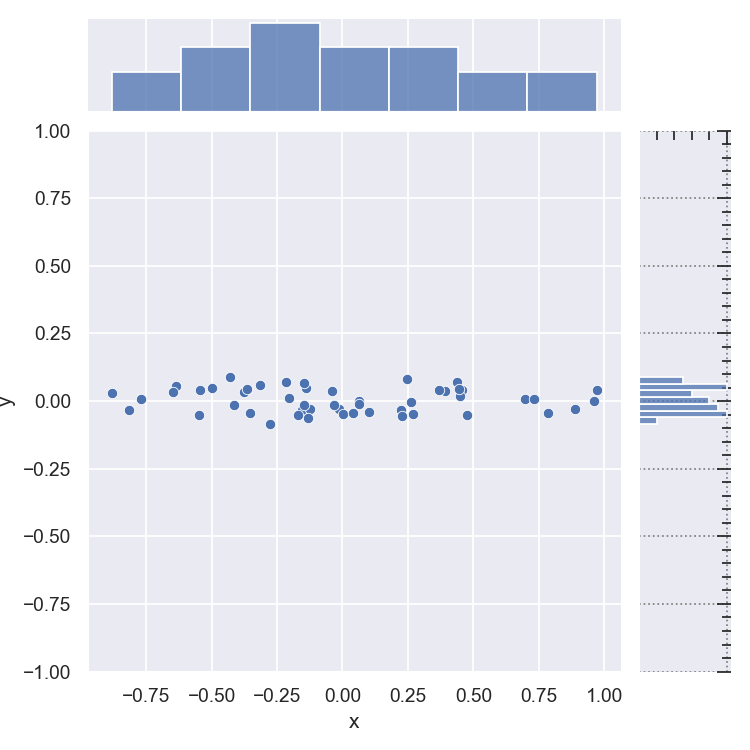

In [8]:
data['y'] = gen.normal(scale = 0.04, size = len(data))
sns.jointplot(x = 'x', y = 'y', data = data)
plt.ylim(-1, +1)
opt_plot()

<IPython.core.display.Javascript object>


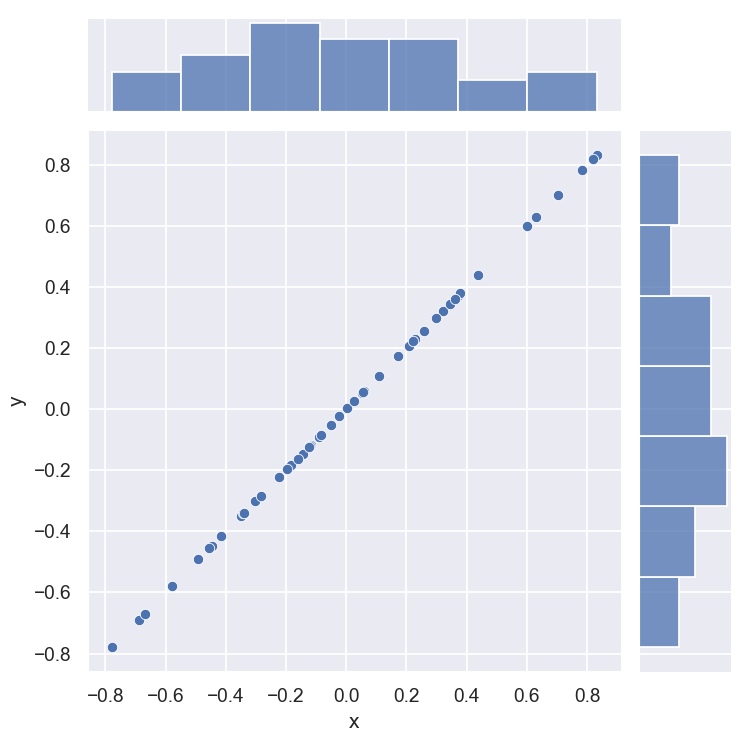

In [9]:
theta = np.deg2rad(30.)
rotated = data.copy()
rotated['x'] = np.cos(theta) * data['x'] - np.sin(theta) * data['y']
rotated['y'] = np.cos(theta) * data['x'] - np.sin(theta) * data['y']
sns.jointplot(x = 'x', y = 'y', data = rotated)

<IPython.core.display.Javascript object>


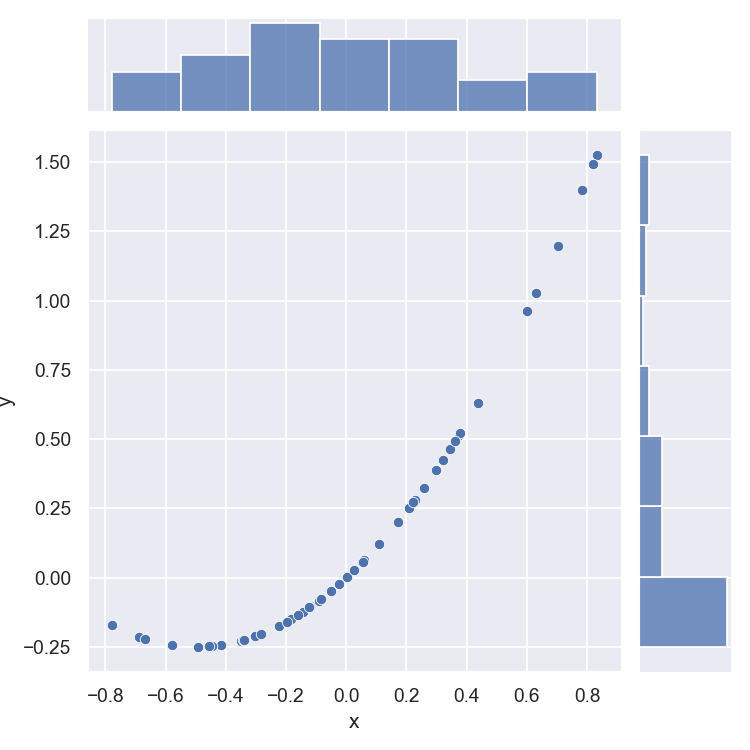

In [10]:
nonlinear = rotated.copy()
nonlinear['y'] = rotated['y'] + rotated['x'] ** 2
sns.jointplot(x = 'x', y = 'y', data = nonlinear)

Usaremos `spectra_data` abaixo. Observe na tabela acima que parece ser severamente subamostrada com $N=200$, $D=500$.

Plote algumas linhas (amostras) de `spectra_data` usando `plt.plot(spectra_data.iloc[i], '.')` para ter uma ideia desse conjunto de dados.

<IPython.core.display.Javascript object>


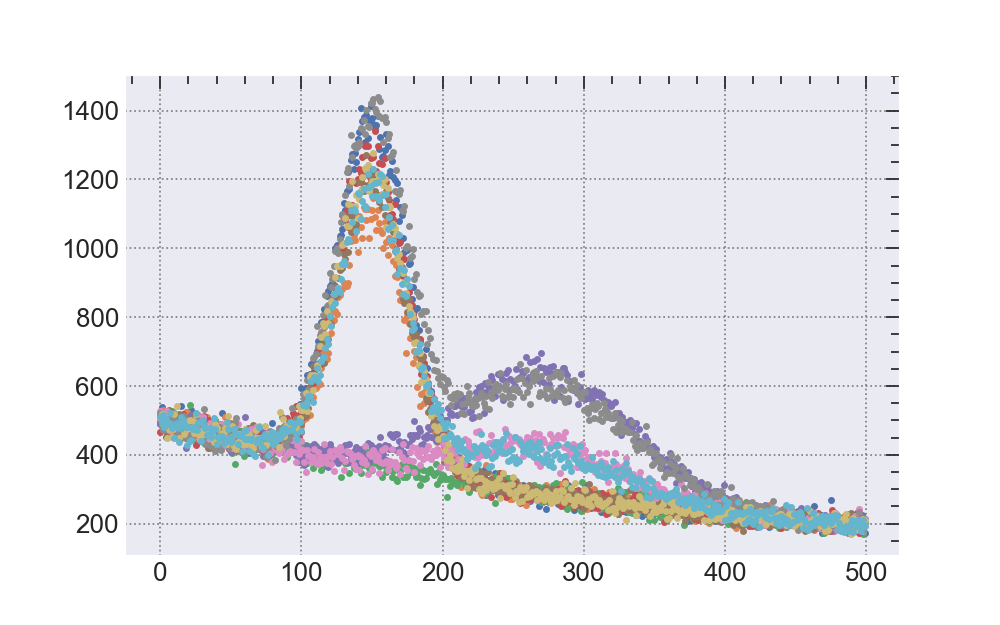

In [11]:
plt.figure(figsize = (8, 5))
opt_plot()
for i in range(10):
    plt.plot(spectra_data.iloc[i], '.')  

**QUESTIONAMENTO:** Qual você acha que é a dimensionalidade efetiva desses dados? (*Dica*: quantos parâmetros independentes você precisaria para gerar esses dados?)

Cada amostra é um gráfico de uma função suave com algum ruído adicionado. A função suave tem três componentes distintos:

- dois picos, com localizações e formas fixas, e normalizações que variam independentemente.

- um plano de fundo suave sem parâmetros livres. Como os dados podem ser reproduzidos apenas com parâmetros de normalização (exceto o ruído), eles têm uma dimensionalidade efetiva de $d=2$.

Observe que a normalização relativa de cada recurso é significativa aqui, portanto, não gostaríamos de normalizar esses dados e perder essas informações. Referimo-nos a cada amostra como um "espectro", uma vez que se parece com espectros obtidos em diferentes áreas da física (astronomia, física nuclear, física de partículas, ...)

## 1. Decomposição linear

O objetivo de uma decomposição linear é identificar automaticamente combinações lineares das características originais que respondem pela maior parte da variação nos dados. Observe que estamos usando variância (*spread*) como *proxy* para "informações úteis", portanto, é essencial que a normalização relativa de nossos recursos seja significativa.

Se representarmos nossos dados com $N\times D$ a matriz $X$, então uma decomposição linear pode ser representada como a seguinte multiplicação de matrizes:

![image](img/LinearDecomposition.png)

A matriz $Y$ com $N\times d$ é uma representação reduzida dos dados originais $X$, com $d<D$ novos recursos que são combinações lineares do recurso original $D$. Chamamos os novos recursos de "variáveis latentes", uma vez que eles já estavam presentes, mas apenas de forma implícita.

A matriz $M$ com $d\times D$ especifica a relação entre os recursos antigos e novos: cada coluna é um vetor unitário para um novo recurso em termos dos recursos antigos. Observe que $M$ não é quadrado quando $d<D$ e vetores unitários geralmente não são mutuamente ortogonais (exceto para o método PCA).

Uma decomposição linear não é exata (daí o $\approxeq$ acima) e não há "melhor" prescrição para determinar $Y$ e $M$. Abaixo, revisamos as prescrições mais populares implementadas no módulo [`sklearn.decomposition`](https://scikit-learn.org/stable/modules/decomposition.html):

| Método | `sklearn` |
| --- | --- |
| [*Principal Component Analysis*](https://en.wikipedia.org/wiki/Principal_component_analysis) | [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) |
| [*Factor Analysis*](https://en.wikipedia.org/wiki/Factor_analysis) | [FactorAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html) |
| [*Non-negative Matrix Factorization*](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) | [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) |
| [*Independent Component Analysis*](https://en.wikipedia.org/wiki/Independent_component_analysis) | [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) |

Todos os métodos requerem que você especifique o número de variáveis latentes $d$ (mas você pode facilmente experimentar com valores diferentes) e são chamados usando (método = PCA, FactorAnalysis, NMF, FastICA):

```Python
fit = decomposition.method(n_components=d).fit(X)
```

A decomposição resultante em $Y$ e $M$ é dada por:

```Python
M = fit.components_
Y = fit.transform(X)
```

exceto para FastICA, onde `M = fit.mixing_.T`.

Quando $d<D$, nos referimos à decomposição como uma "redução de dimensionalidade". Uma visualização útil de quão efetivamente as variáveis latentes capturam as informações interessantes nos dados originais é calcular:

$$X'=YM,$$

que reconstrói aproximadamente os dados originais e compara linhas (amostras) de $X'$ com o $X$ original. Eles não concordarão exatamente, mas se as diferenças parecerem desinteressantes (por exemplo, parecerem ruído), a redução de dimensionalidade foi bem-sucedida e você poderá usar em vez de para análise subsequente.

Usaremos a função abaixo para demonstrar cada um deles (mas você pode ignorar seus detalhes, a menos que esteja interessado):

In [12]:
def demo(method='PCA', d=2, data=spectra_data):
    
    X = data.values
    N, D = X.shape
    
    if method == 'NMF':
        # Todos os dados devem ser positivos.
        assert np.all(X > 0)
        # A análise inclui a média.
        mu = np.zeros(D)
    else:
        mu = np.mean(X, axis=0)
        
    kwargs = dict(n_components=d)
    if method == 'NMF':
        kwargs['max_iter'] = 500
    fit = eval('decomposition.' + method)(**kwargs).fit(X)
    
    # Verifique se a decomposição tem a forma esperada.
    if method == 'FastICA':
        M = fit.mixing_.T
    else:
        M = fit.components_
    assert M.shape == (d, D)
    Y = fit.transform(X)
    assert Y.shape == (N, d)
    
    # Reconstrua X - mu do Y, M ajustado.
    Xr = np.dot(Y, M) + mu
    assert Xr.shape == X.shape
    
    # Pares de plotagem de variáveiss latentes.
    columns = ['y{}'.format(i) for i in range(d)]
    sns.pairplot(pd.DataFrame(Y, columns=columns))
    plt.show()
    
    # Compare algumas amostras de X e Xr.
    fig = plt.figure(figsize=(8.5, 4))
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c = c, ms = 3, alpha = 0.5)
        plt.plot(Xr[i], '-', c = c, lw = 2)
        
    plt.xlim(-0.5, D+0.5)
    plt.xlabel('Feature #')
    plt.ylabel('Feature Value')
    label = '{}(d = {}): $\sigma = {:.2f}$'.format(method, d, np.std(Xr - X))
    plt.text(0.95, 0.9, label, horizontalalignment = 'right',
             fontsize = 'x-large', transform = plt.gca().transAxes)
    opt_plot()

## 2. Análise do componente principal (PCA)

PCA é o método mais comumente usado para redução de dimensionalidade. A decomposição é especificada exclusivamente pela seguinte prescrição (mais detalhes [aqui](https://en.wikipedia.org/wiki/Principal_component_analysis#Computing_PCA_using_the_covariance_method)):

1. Ache os autovalores e autovetores de
$$C=\frac{1}{N-1}X^{T}X$$
que é uma [estimativa empírica](https://en.wikipedia.org/wiki/Covariance#Calculating_the_sample_covariance) da matriz de covariância para os dados.

2. Construa $M$ a partir dos autovetores, ordenados por autovalores decrescentes (que são todos positivos) e resolva as equações lineares resultantes para $Y$. Neste ponto a decomposição é exata com $d=D$.

3. Encolher $Y$ e $M$ de $D$ para $d$ linhas ($M$) ou colunas ($Y$), o que torna a decomposição aproximada enquanto descarta a menor quantidade de variação nos dados originais (que usamos como *proxy* para "informações úteis").
![image](img\PCAdecomposition.png)

A matriz completa $M$ (antes do encolhimento $D\rightarrow d$) é ortogonal, ou seja $M^{T}=M^{-1}$ , e satisfaz $X^{T}X=M^{T}\Lambda M$, onde $\Lambda$ é uma matriz diagonal dos autovalores decrescentes. Observe que esta descrição ignora alguns detalhes que serão explorados na lista de problemas propostos.

As variáveis latentes resultantes são *estatisticamente não correlacionadas* (o que é uma afirmação mais fraca do que *estatisticamente independente* - veja abaixo), ou seja, os [coeficientes de correlação](https://en.wikipedia.org/wiki/Correlation_coefficient) entre as diferentes colunas de $Y$ são aproximadamente zero:

$$\rho(j,k)=\frac{Y_{j}\cdot Y_{k}}{|Y_{j}|\cdot|Y_{k}|}\approxeq0$$

A demonstração do PCA abaixo mostra um gráfico de pares das variáveis latentes de uma decomposição com $d=2$, seguido por uma reconstrução de algumas amostras (curvas vermelhas) comparadas com as originais (pontos vermelhos).

Observe que as amostras reconstruídas são, em certo sentido, melhores que as originais, pois o ruído original foi associado a um pequeno valor próprio que foi cortado!

<IPython.core.display.Javascript object>


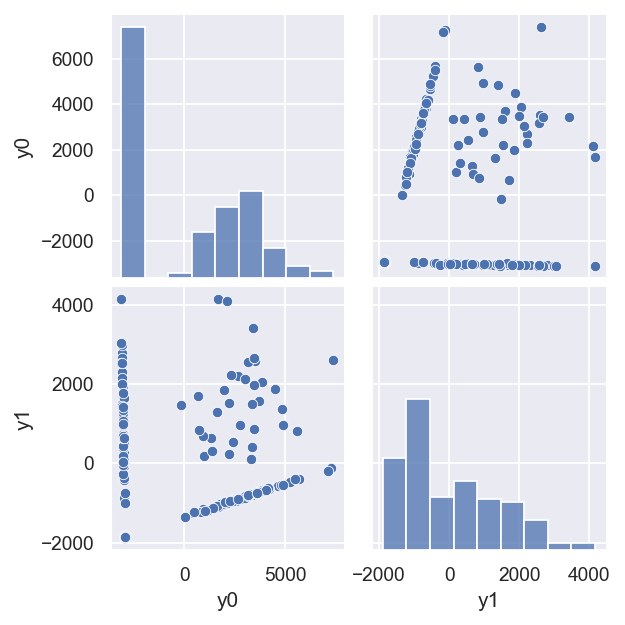

<IPython.core.display.Javascript object>


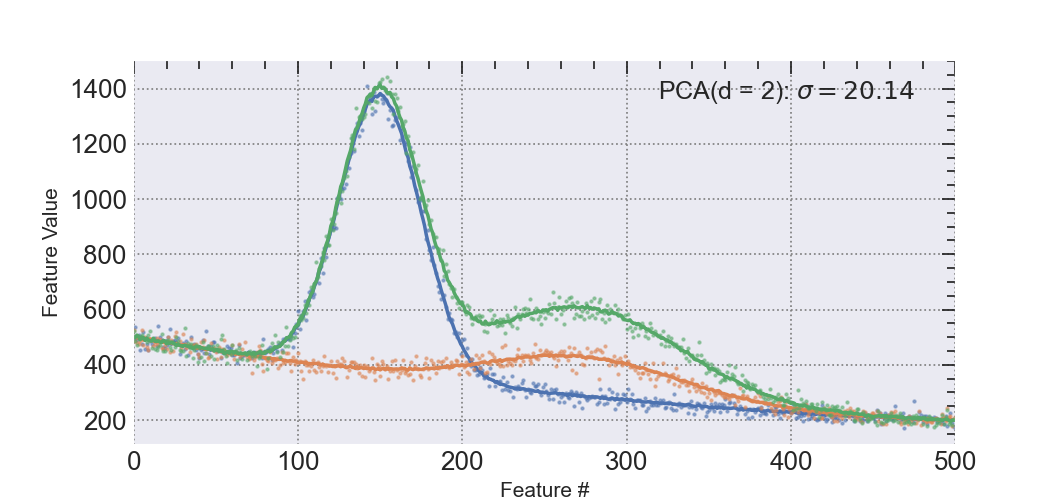

In [13]:
demo('PCA', d = 2)

**QUESTIONAMENTO:** Quantos *clusters* você espera ver no gráfico de dispersão de `y0` versus `y1` acima com base no que você sabe sobre esse conjunto de dados? Você consegue identificar esses clusters no gráfico acima?

Esperamos ver 4 clusters, correspondendo a espectros com:

- Sem picos.

- Apenas o pico inferior.

- Apenas o pico superior.

- Ambos os picos.

Já vimos que esses dados podem ser gerados a partir de dois valores de fluxo, dando a normalização de cada pico. Vamos supor que `y0` e `y1` estejam relacionados a esses fluxos para identificar os clusters:

- Pontos próximos (-2000, -2000), com muito pouco *spread*.

- Pontos ao longo da linha horizontal com `y0 ~ -2000`.

- Pontos ao longo da linha diagonal.

- Pontos espalhados entre as duas linhas.

## 3. Análise de fatores

A análise de fatores (FA) geralmente produz resultados semelhantes à PCA, mas é conceitualmente diferente.

Tanto o PCA quanto o FA assumem implicitamente que os dados são amostrados aproximadamente de uma Gaussiana multidimensional. O PCA então encontra os eixos principais do elipsóide multidimensional resultante, enquanto o FA é baseado em um modelo de como os dados originais são gerados a partir das variáveis latentes. Especificamente, o FA busca variáveis latentes que são unidades gaussianas não correlacionadas e permite diferentes níveis de ruído em cada característica, assumindo que esse ruído não está correlacionado com as variáveis latentes. O PCA não distingue entre "sinal" e "ruído" e assume implicitamente que os autovalores grandes são mais parecidos com sinal e os pequenos mais parecidos com ruído.

Quando as suposições de FA sobre os dados (de variáveis latentes gaussianas com ruído não correlacionado adicionado) estão corretas, certamente é a melhor escolha, em princípio. Na prática, a decomposição FA é mais cara e requer um algoritmo iterativo de *Expectation-Maximization* (EM). Normalmente, você deve tentar os dois, mas prefira o PCA mais simples quando os resultados forem indistinguíveis.

<IPython.core.display.Javascript object>


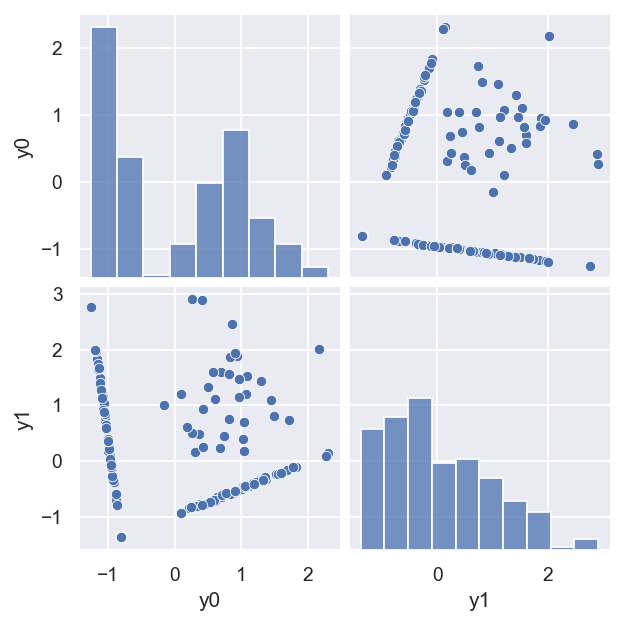

<IPython.core.display.Javascript object>


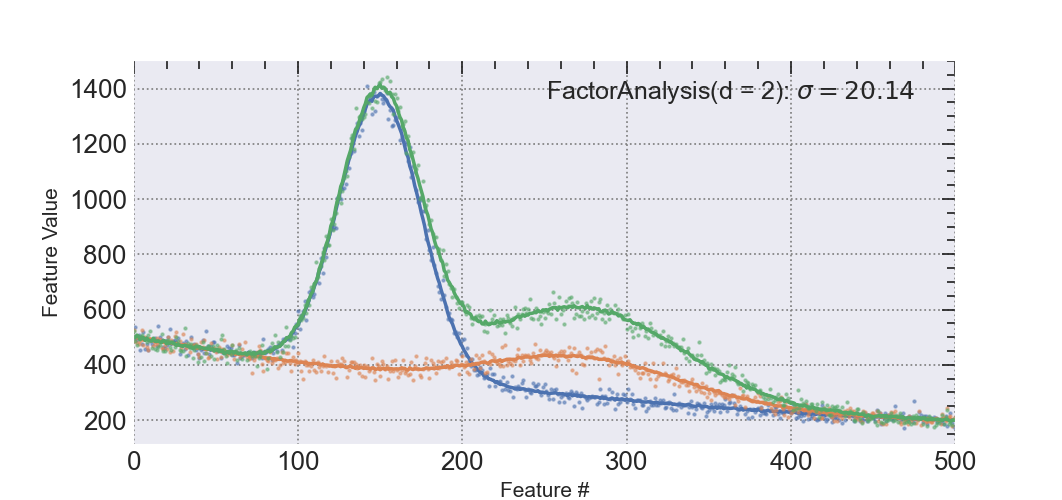

In [14]:
demo('FactorAnalysis', d = 2)

## 4. Fatoração de matriz não negativa

A maioria das fatorações lineares começa centralizando cada recurso em torno de sua média sobre as amostras:

$$X_{ij}\rightarrow X_{ij}-\mu\text{ }\text{ }\text{ , }\text{ }\text{ }\mu_{ij}\equiv\frac{1}{N}\sum_{i}X_{ij}$$

Como resultado, as variáveis latentes são igualmente prováveis de serem positivas ou negativas.

A fatoração de matriz não negativa (NMF) assume que os dados são uma superposição linear (possivelmente ruidosa) de diferentes componentes, o que geralmente é uma boa descrição dos dados resultantes de um processo físico. Por exemplo, o espectro de uma galáxia é uma superposição dos espectros de suas estrelas constituintes, e o espectro de uma amostra radioativa é uma superposição dos decaimentos de seus isótopos instáveis constituintes.

Esses processos só podem **adicionar** dados, portanto, os elementos de $Y$ e $M$ devem ser todos $\geq0$ se as variáveis latentes descreverem misturas aditivas de diferentes processos. A fatoração NMF garante que ambos $Y$ e $M$ são positivos, e requer que a entrada $X$ também seja positiva. No entanto, não há garantia de que as variáveis latentes não negativas encontradas pelo NMF sejam devidas a misturas físicas.

Como o NMF não subtrai internamente as médias $\mu_{ij}$, geralmente precisa de um componente adicional para modelar a média. Para `spectra_data` então, devemos usar `d = 3` para NMF para comparar com PCA usando `d = 2`:

C:\Users\Gabriel Wendell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


<IPython.core.display.Javascript object>


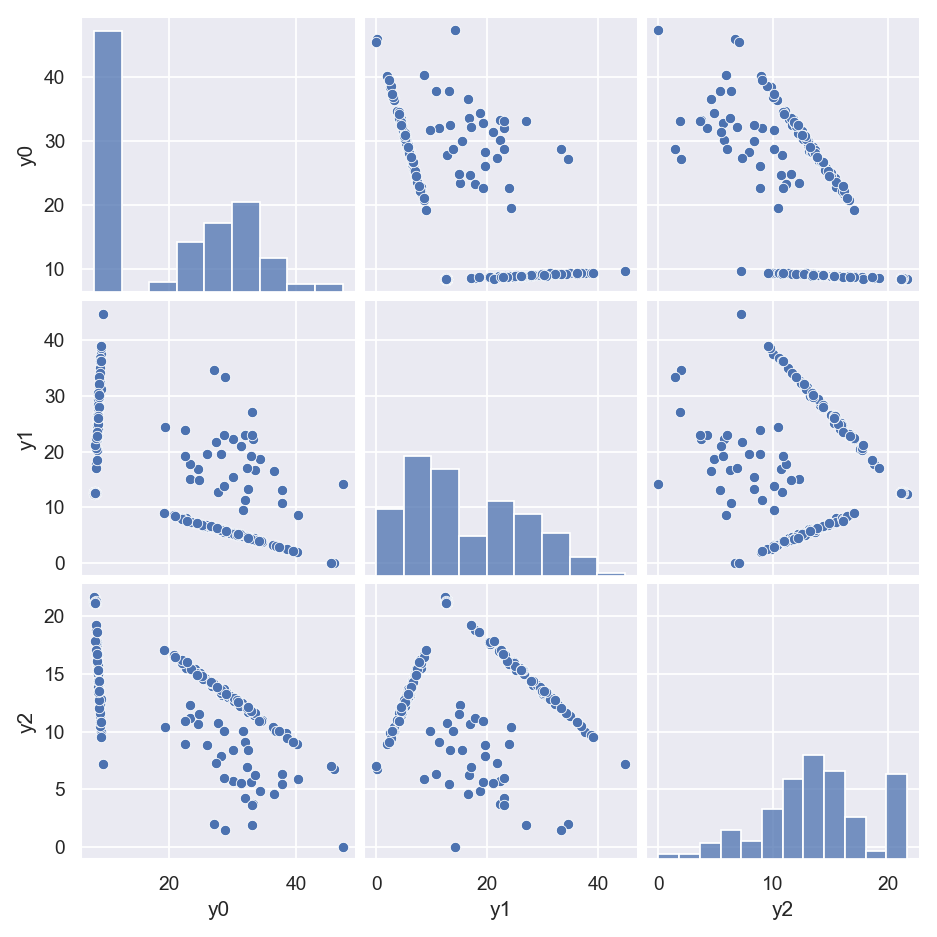

<IPython.core.display.Javascript object>


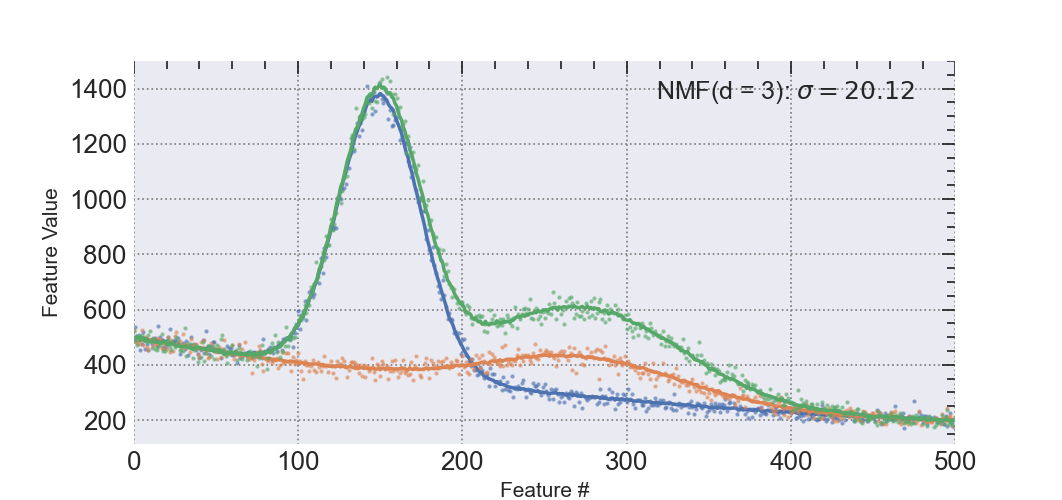

In [15]:
demo('NMF', d = 3)

Para ver a importância da variável extra latente, tente com `d = 2` e observe como as amostras são mal reconstruídas:

C:\Users\Gabriel Wendell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


<IPython.core.display.Javascript object>


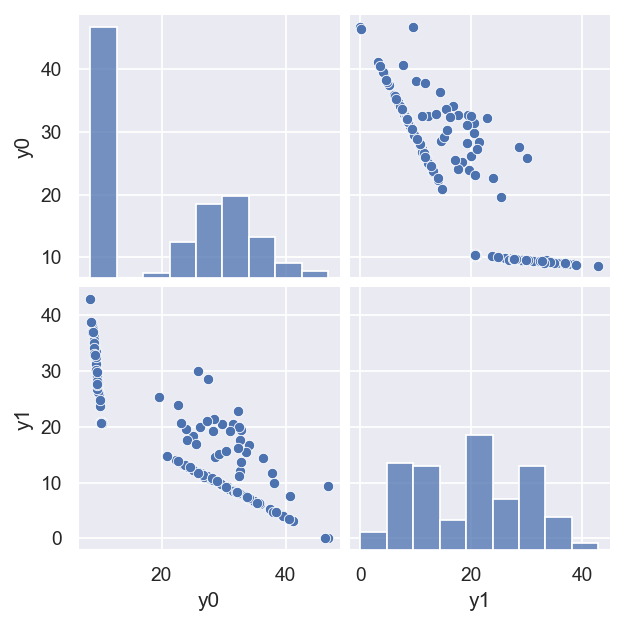

<IPython.core.display.Javascript object>


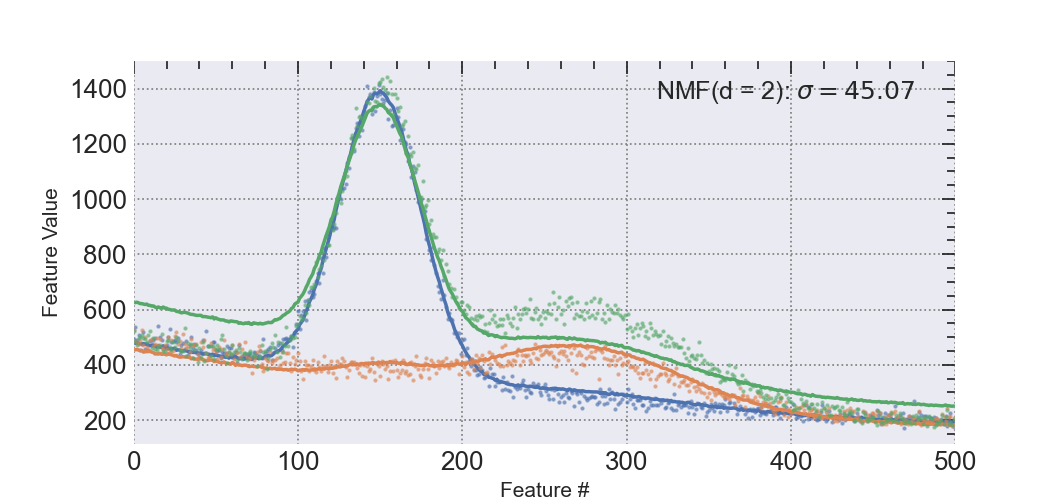

In [16]:
demo('NMF', d = 2)

## 5. Análise de componentes independentes

A decomposição linear final que consideraremos é a ICA, onde o objetivo é encontrar variáveis latentes $Y$ que sejam *estatisticamente independentes*, o que é uma afirmação mais forte do que a garantia *estatisticamente não correlacionada* da PCA. Vamos formalizar a definição de independência em breve, mas a ideia básica é que a probabilidade conjunta de uma amostra ocorrer com variáveis latentes $y_{1},y_{2},y_{3},\ldots$ pode ser fatorado em probabilidades independentes para cada componente:

$$P(y_{1},y_{2},y_{3},\ldots)=P(y_{1})P(y_{2})P(y_{3})\ldots$$

O ICA tem algumas ambiguidades inerentes: tanto a ordenação quanto o dimensionamento das variáveis latentes são arbitrários, ao contrário do PCA. No entanto, na prática, as amostras reconstruídas com ICA muitas vezes parecem semelhantes às reconstruções de PCA e FA.

O ICA também é usado para [separação de sinal cego](https://en.wikipedia.org/wiki/Signal_separation), onde geralmente $d=N$.

<IPython.core.display.Javascript object>


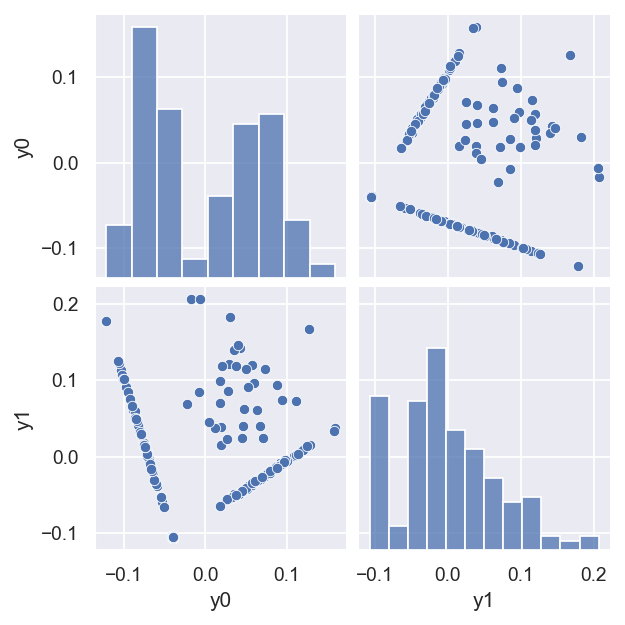

<IPython.core.display.Javascript object>


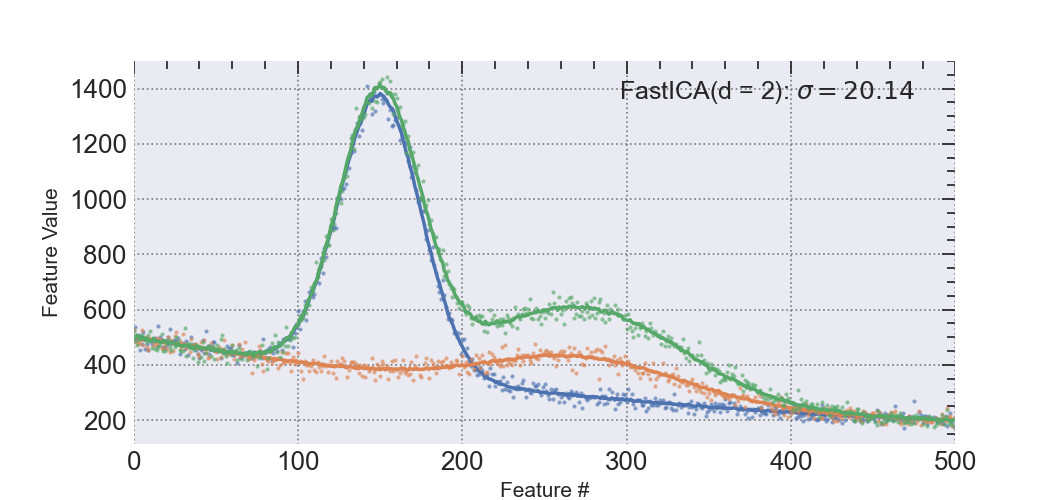

In [17]:
demo('FastICA', d = 2)

## 6. Comparação de Métodos Lineares

Para comparar os quatro métodos acima, plote seus "vetores unitários" normalizados (linhas da matriz $M$). Observe que apenas as curvas NMF são sempre positivas, como esperado. No entanto, embora todos os métodos forneçam excelentes reconstruções dos dados originais, todos eles também misturam os dois picos. Em outras palavras, nenhum dos métodos descobriu as variáveis latentes naturais do processo físico subjacente: as normalizações de pico individuais.

<IPython.core.display.Javascript object>


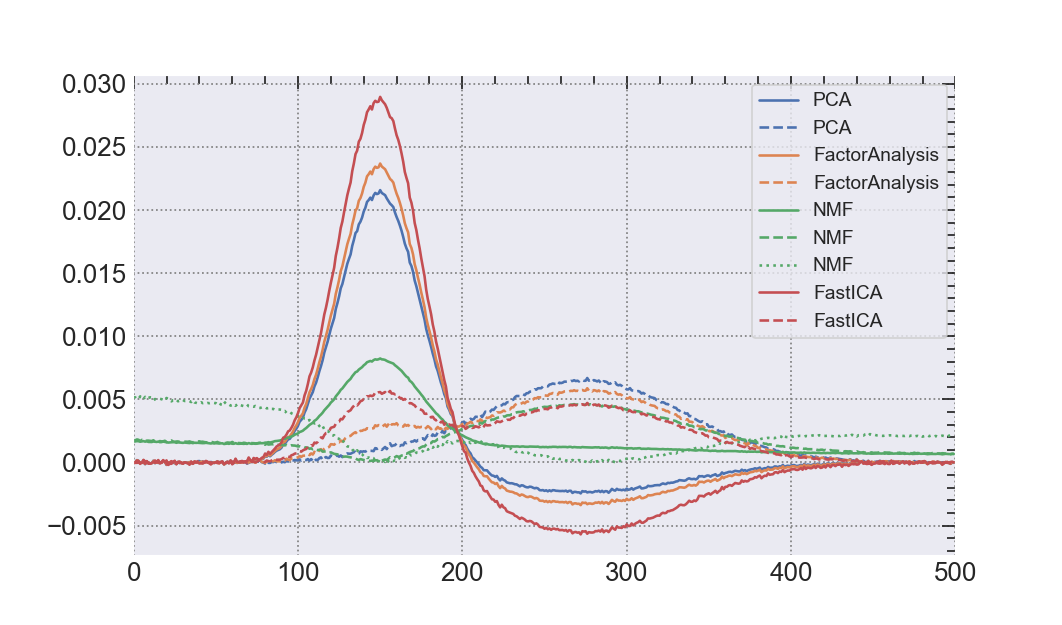

C:\Users\Gabriel Wendell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [18]:
def compare_linear(data = spectra_data):
    X = data.values
    N, D = X.shape
    fig = plt.figure(figsize=(8.5, 5))
    for j, method in enumerate(('PCA', 'FactorAnalysis', 'NMF', 'FastICA')):
        if method == 'NMF':
            d = 3
            mu = np.zeros(D)
        else:
            d = 2
            mu = np.mean(X, axis=0)
        kwargs = dict(n_components=d)
        if method == 'NMF':
            kwargs['max_iter'] = 500
        fit = eval('decomposition.' + method)(**kwargs).fit(X - mu)
        M = fit.mixing_.T if method == 'FastICA' else fit.components_
        for i in range(d):
            unitvec = M[i] / M[i].sum()
            plt.plot(unitvec, label=method, c=sns.color_palette()[j], ls=('-', '--', ':')[i])
    plt.legend()
    opt_plot()
    plt.xlim(-0.5, D + 0.5)
    
compare_linear()

## 7. PCA ponderado

Os algoritmos lineares apresentados acima funcionam bem com dados ruidosos, mas não têm como tirar proveito de dados que incluem sua própria estimativa do nível de ruído. No caso mais geral, cada elemento da matriz $X$ de dados possui uma estimativa de erro RMS $\delta X$ correspondente, com valores $\rightarrow\infty$ usados para indicar dados ausentes. Na prática, é conveniente substituir $\delta X$ por uma matriz de pesos $W$ onde valores zero indicam dados ausentes. Para dados com erros gaussianos, $X_{ij}\pm\delta X_{ij}$, o peso apropriado é geralmente a *variância inversa* $I\equiv\delta X_{ij}^{-2}$.

[Delchambre 2015](https://arxiv.org/abs/1412.4533) revisa várias abordagens para calcular componentes principais de dados ponderados e propõe um novo esquema onde, em vez de subtrair a média usual, subtraímos uma média ponderada,

$$\mu_{j}=\frac{\sum_{i=1}^{N}W_{ij}X_{ij}}{\sum_{i=1}^{N}W_{ij}},$$

com $W=\sqrt{I}$, e, em vez de decompor $C=X^{T}X$, nós decompomos

$$C=\frac{(WX)^{T}(WX)}{W^{T}W}$$

A classe abaixo implementa este esquema seguindo a mesma API da classe `sklearn` PCA:

In [19]:
# Use scipy.linalg.eigh ao invés de np.linalg.eigh uma vez que nos permite encontrar
# os autovetores com os maiores autovalores.
import scipy.linalg

class WeightedPCA(object):
    """Implementa o esquema PCA ponderado do Delchambre 2015.
    
    Consulte https://arxiv.org/abs/1412.4533 e uma implementação mais completa
    em https://github.com/jakevdp/wpca.
    """
    def __init__(self, n_components):
        self.n_components = n_components
        
    def prepare(self, X, ivar=None):
        if ivar is None:
            W = np.ones_like(X)
        else:
            assert np.all(ivar >= 0)
            W = np.sqrt(ivar)
        # Calcule a média ponderada dos dados usando a Eq (2).
        self.mu = np.sum(W * X, axis=0) / np.sum(W, axis=0)
        # Subtraia a média ponderada dos dados.
        X = X - self.mu
        # Aplique pesos aos dados (média subtraída).
        X *= W
        return X, W

    def fit(self, X, ivar=None):
        X, W = self.prepare(X, ivar)
        # Calcule a covariância ponderada..
        C = np.dot(X.T, X)
        C /= np.dot(W.T, W)
        # Encontre os autovetores e autovalores de C
        _, D = X.shape
        evals, evecs = scipy.linalg.eigh(C, eigvals=(D - self.n_components, D - 1))
        # Salve os resultados.
        self.components_ = evecs[:, ::-1].T
        return self
        
    def transform(self, X, ivar=None):
        X, W = self.prepare(X, ivar)
        N, _ = X.shape
        Y = np.zeros((N, self.n_components))
        for i in range(N):
            cW = self.components_ * W[i]
            cWX = np.dot(cW, X[i])
            cWc = np.dot(cW, cW.T)
            Y[i] = np.linalg.solve(cWc, cWX)
        return Y
    
    def inverse_transform(self, X):
        return self.mu + np.dot(X, self.components_)

Para estudar esses esquemas, atribuiremos pesos a `spectra_data` assumindo que cada valor $X_{ij}$ é o resultado de um processo de Poisson, então tem variância inversa $I=X_{ij}^{-1}$.

A função abaixo nos permite, opcionalmente, adicionar ruído extra que varia entre os espectros e remover pedaços aleatórios de dados (definindo seus pesos como zero). Como de costume, ignore os detalhes desta função, a menos que esteja interessado.

In [20]:
def weighted_pca(d=2, add_noise=None, missing=None, data=spectra_data, seed=123):
    gen = np.random.RandomState(seed=seed)
    X = data.values.copy()
    N, D = X.shape
    # Calcule as variâncias inversas assumindo flutuações de Poisson em X.
    ivar = X ** -1
    
    # Adicione algum ruído gaussiano com um RMS linearmente variável, se solicitado.
    if add_noise:
        start, stop = add_noise
        assert start >= 0 and stop >= 0
        extra_rms = np.linspace(start, stop, D)
        ivar = (X + extra_rms ** 2) ** -1
        X += gen.normal(scale=extra_rms, size=X.shape)
        
    # Remova alguma fração de dados de cada amostra, se solicitado.
    if missing:
        assert 0 < missing < 0.5
        start = gen.uniform(high=(1 - missing) * D, size=N).astype(int)
        stop = (start + missing * D).astype(int)
        for i in range(N):
            X[i, start[i]:stop[i]] = ivar[i, start[i]:stop[i]] = 0.
            
    # Execute o ajuste.
    fit = WeightedPCA(n_components=d).fit(X, ivar)
    Y = fit.transform(X, ivar)
    Xr = fit.inverse_transform(Y)
    
    # Mostre a reconstrução de algumas amostras.
    fig = plt.figure(figsize=(8.5, 4))
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c=c, ms=3, alpha=0.5)
        plt.plot(Xr[i], '-', c=c, lw=2)
    plt.xlim(-0.5, D+0.5)
    plt.xlabel('Feature #')
    plt.ylabel('Feature Value')
    opt_plot()

Primeiro, verifique se recuperamos resultados semelhantes ao PCA padrão sem ruído adicionado ou dados ausentes. Os resultados não são idênticos (mas presumivelmente melhores agora) porque estamos levando em conta o fato de que os erros relativos são maiores para fluxos mais baixos.

<IPython.core.display.Javascript object>


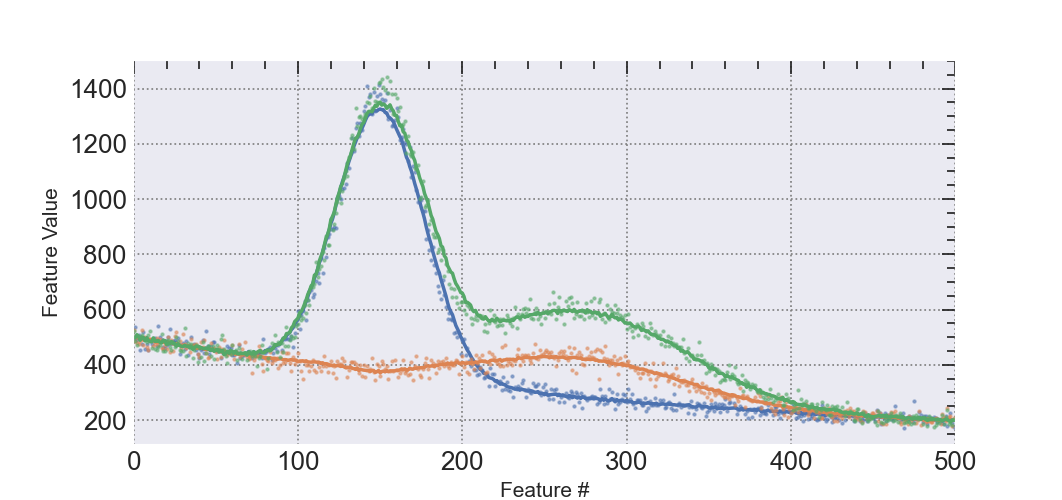

In [21]:
weighted_pca(d = 2)

Em seguida, varie o nível de ruído no espectro. Os erros maiores dificultam a fixação dos componentes principais, levando a reconstruções mais ruidosas:

<IPython.core.display.Javascript object>


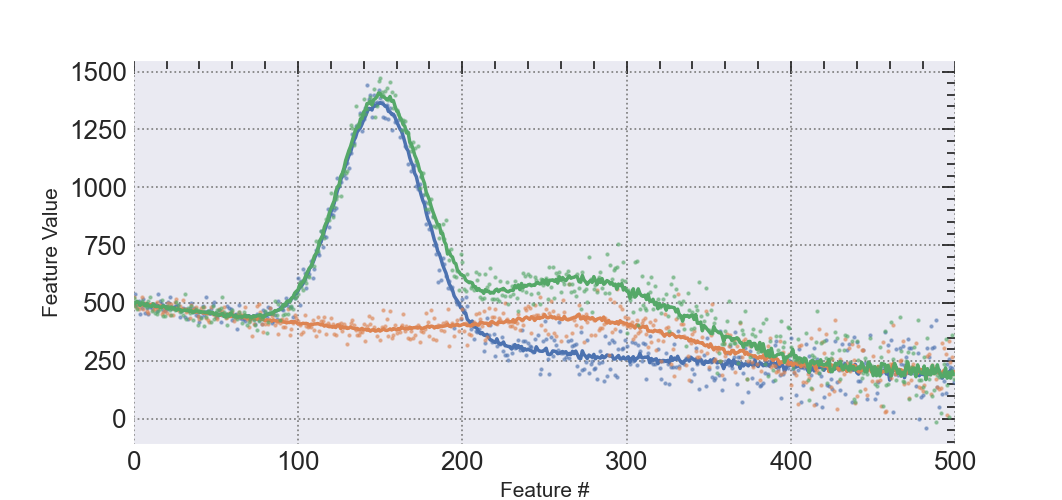

In [22]:
weighted_pca(d = 2, add_noise = (0, 100))

<IPython.core.display.Javascript object>


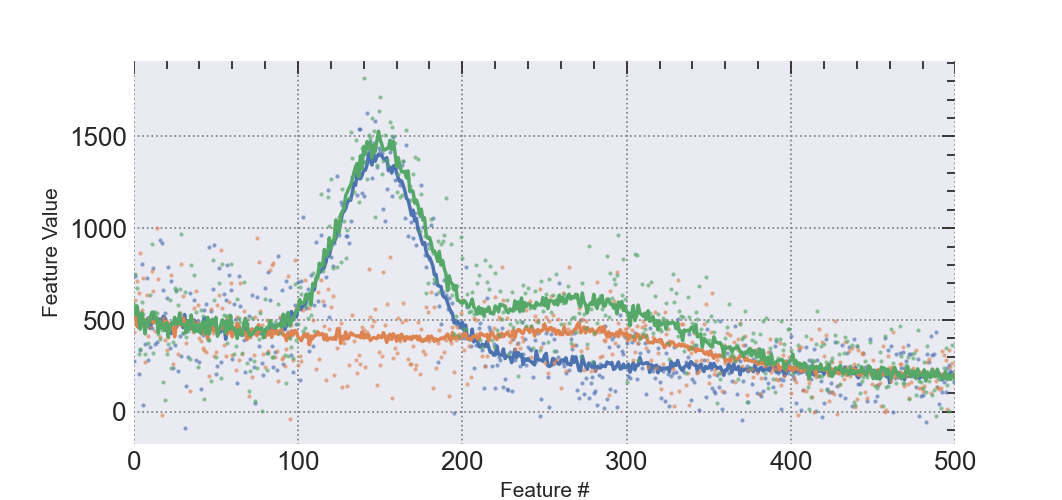

In [23]:
weighted_pca(d = 2, add_noise = (200, 100))

Finalmente, remova 10% dos dados de cada amostra (mas, crucialmente, 10% diferente de cada amostra). Observe como isso nos permite fazer uma estimativa sensata dos dados ausentes! (os estatísticos chamam isso de [imputação](https://en.wikipedia.org/wiki/Imputation_(statistics)).

<IPython.core.display.Javascript object>


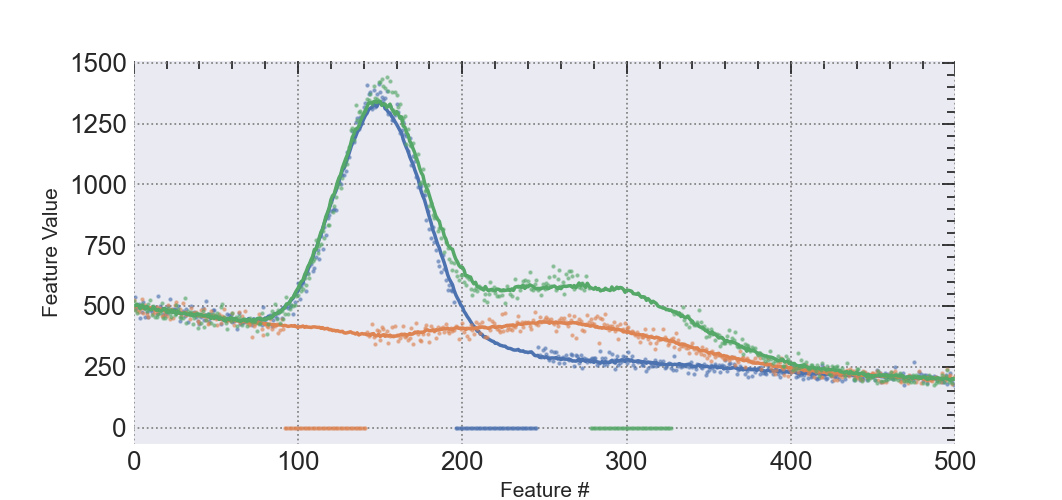

In [24]:
weighted_pca(d = 2, missing = 0.1, seed = 2)

## 8. Redução de Dimensionalidade Não Linear

Os métodos acima encontram variáveis latentes que são funções lineares das características originais.

Existem também métodos não lineares:

- Quando funcionam, os resultados são [espetaculares](https://scikit-learn.org/stable/modules/manifold.html) (veja também [aqui](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html)).

- No entanto, eles geralmente são muito [sensíveis à sua escolha de hiperparâmetros](https://github.com/scikit-learn/scikit-learn/issues/10530).

- Eu recomendo que você sempre comece com um método linear e só prefira um modelo não linear se ele tiver um desempenho claramente melhor e fornecer resultados consistentes e robustos.

Na aula do último dia deste minicurso iremos dar um mergulho mais profundo em métodos não lineares. Uma ideia-chave é o "*truque do kernel*", que também é central para o poder das redes neurais.

## 9. Compressão Orientada por Modelo

A maioria dos métodos de redução de dimensionalidade assume que a variância é uma boa *proxy* para "informação". No entanto, quando você tem um bom modelo generativo de seus dados, pode fazer muito melhor. Em particular, existe um algoritmo de compactação ideal para dados gerados por um modelo $n$ com parâmetros que reduzirão todo o seu conjunto de dados a $n$ números! Consulte este [artigo de 2018](https://doi.org/10.1093/mnras/sty819) para obter detalhes.

![image](https://c.tenor.com/hEOM8E4epvgAAAAC/hahaha-thats-all-folks.gif)

---

## Para se divertir!

- [Lista de problemas #04](https://github.com/GabrielWendell/Intro_ML/blob/main/Listas/Problemas4.ipynb)

---